# Multimodal PDF search

Index a set of PDFs using multi-modal embeddings [vidore/colpali-v1.2](https://huggingface.co/vidore/colpali-v1.2)

## Download dataset 

In [1]:
# Download a set of arxiv papers

# !aws s3 cp s3://arxiv/pdf/arXiv_pdf_2401_001.tar arxiv_data/ --request-payer
# !cd arxiv_data && tar -xzvf arXiv_pdf_2401_001.tar
# !aws s3 cp 2401 s3://<bucket>/<path> --recursive

## Setup

In [2]:
# Import libraries
from tiledb.vector_search.object_readers import DirectoryImageReader
from tiledb.vector_search.embeddings.colpali_embedding import ColpaliEmbedding
from tiledb.vector_search.object_api import object_index
import tiledb.vector_search as vs
import tiledb
import os
from dotenv import load_dotenv
from tiledb.vector_search import _tiledbvspy as vspy

load_dotenv()
config = tiledb.cloud.Config().dict()
config["vfs.s3.aws_access_key_id"] = os.environ["AWS_ACCESS_KEY_ID"]
config["vfs.s3.aws_secret_access_key"] = os.environ["AWS_SECRET_ACCESS_KEY"]

## Create index

Create a vector search index using:
- `DirectoryImageReader` to split PDFs in one image per page
- `ColpaliEmbedding` for multi-modal embeddings

In [3]:
reader = DirectoryImageReader(
    search_uri="s3://tiledb-nikos/vector-search/demo/object_api/documents_demo/arXiv_pdf",
    # include="2401.1617*.pdf",
)
embedding=ColpaliEmbedding()

vector_db_uri="s3://tiledb-nikos/vector-search/demo/object_api/documents_demo/multimodal_search_index"
vfs = tiledb.VFS(config=config)
if vfs.is_dir(vector_db_uri):
    vfs.remove_dir(vector_db_uri)

index = object_index.create(
    uri=vector_db_uri,
    index_type="IVF_FLAT",
    object_reader=reader,
    embedding=embedding,
    metadata_tile_size=1,
    config=config,
)

## Indexing

Distributed indexing with GPU workers for embedding generation in TileDB Cloud.


In [4]:
index.update_index(
    files_per_partition=20,
    config=config,
    embeddings_generation_driver_mode=vs.Mode.BATCH,
    driver_resources={"cpu": "2", "memory": "16Gi"},
    embeddings_generation_mode=vs.Mode.BATCH,
    max_tasks_per_stage=1,
    workers=1,
    extra_worker_modules=["colpali_engine>=0.3.0,<0.4.0", "datasets", "transformers>=4.45.2"],
    worker_resources={"gpu": 1, "memory": "32Gi"},
)

## Query

### Open an existing index

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tiledb
import numpy as np
from tiledb.vector_search.object_api import object_index
import os
from dotenv import load_dotenv

load_dotenv()
config = tiledb.cloud.Config().dict()
config["vfs.s3.aws_access_key_id"] = os.environ["AWS_ACCESS_KEY_ID"]
config["vfs.s3.aws_secret_access_key"] = os.environ["AWS_SECRET_ACCESS_KEY"]

vector_db_uri="s3://tiledb-nikos/vector-search/demo/object_api/documents_demo/multimodal_search_index"

index = object_index.ObjectIndex(
    vector_db_uri,
    config=config,
    open_vector_index_for_remote_query_execution=True,
    load_metadata_in_memory=False,
    memory_budget=1000000,
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Search using text

Query with driver mode, offloading the vector search query to a TileDB Cloud taskgraph.

In [2]:
k=2
d, i = index.query(
    {"text": ["People dancing"]},
    k=k,
    nprobe=5,
    return_objects=False,
    return_metadata=False,
    driver_resource_class="standard",
)

100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


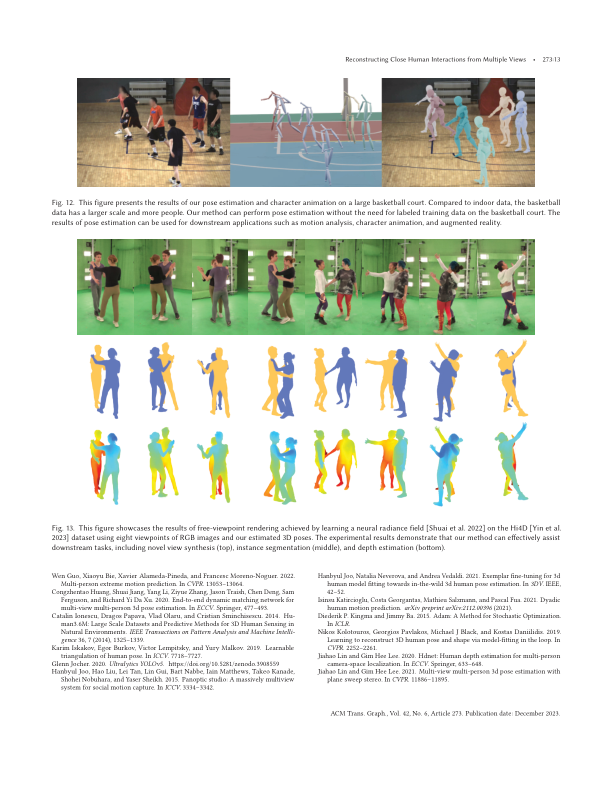

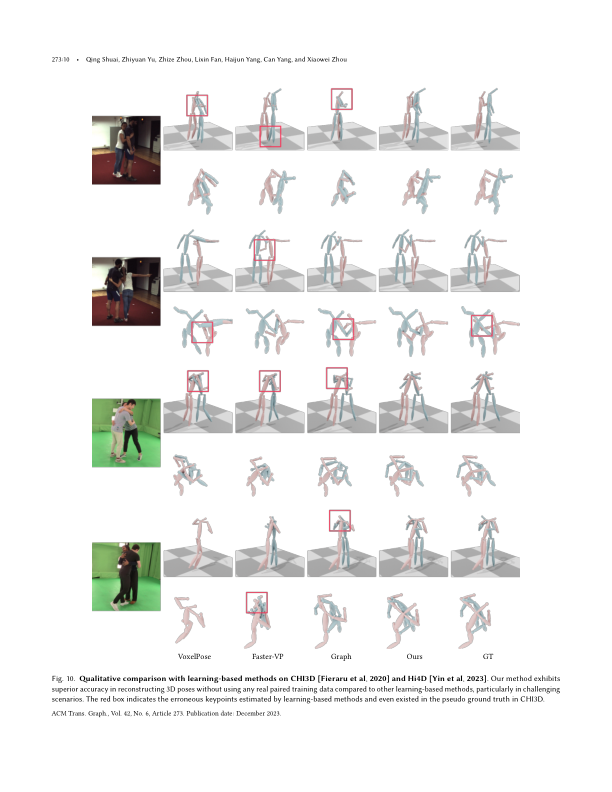

In [3]:
from PIL import Image
for id in range(k):
    res_id = i[0][id]
    metadata = index.metadata_array[res_id]
    display(Image.fromarray(np.reshape(metadata["image"][0], metadata["shape"][0])))